In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
register_matplotlib_converters()
from time import time

<ipython-input-4-770498ee85c7>:3: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  catfish_sales = pd.read_csv('catfish.csv', parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)


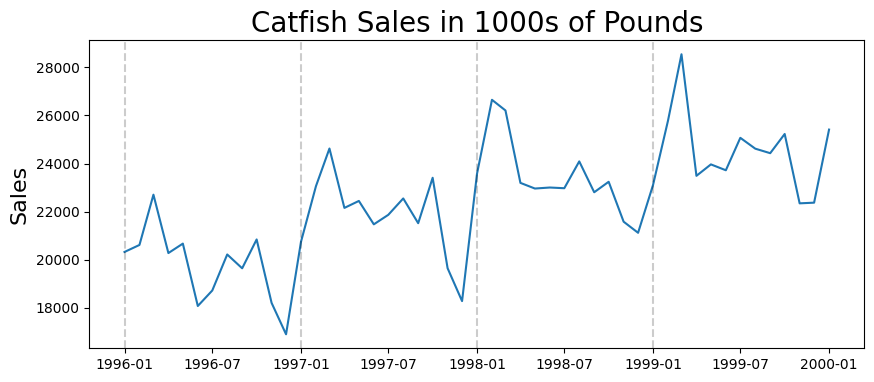

In [4]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')
catfish_sales = pd.read_csv('catfish.csv', parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
catfish_sales = catfish_sales.asfreq(pd.infer_freq(catfish_sales.index))
start_date = datetime(1996,1,1)
end_date = datetime(2000,1,1)
lim_catfish_sales = catfish_sales[start_date:end_date]
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [6]:
first_diff=lim_catfish_sales.diff()[1:]

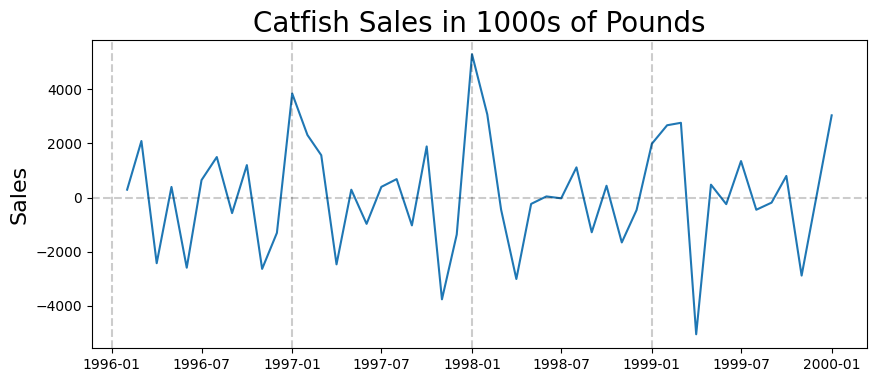

In [7]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

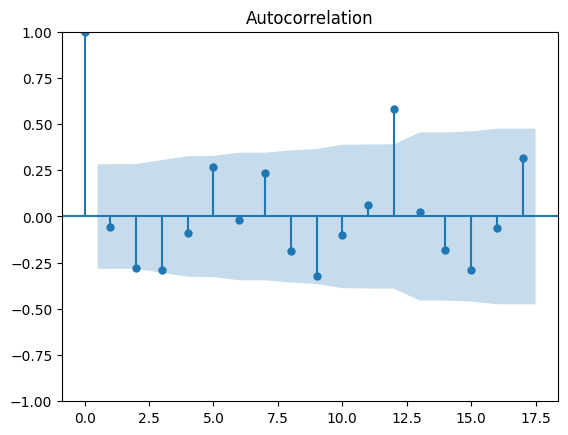

In [11]:
acf_plot=plot_acf(first_diff)

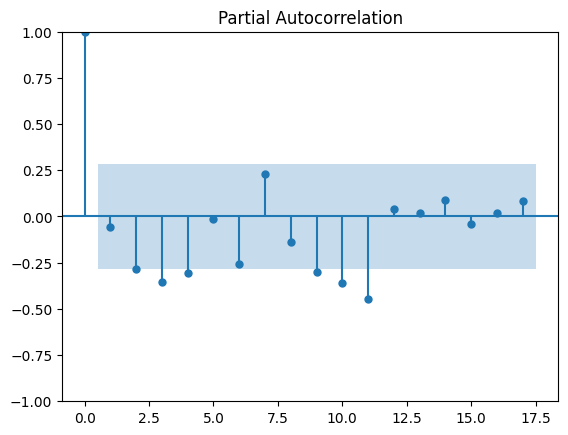

In [12]:
acf_plot=plot_pacf(first_diff)

In [10]:
train_end = datetime(1999,7,1)
test_end = datetime(2000,1,1)

train_data = lim_catfish_sales[:train_end]
test_data = lim_catfish_sales[train_end + timedelta(days=1):test_end]

In [13]:
my_order = (0,1,0)
my_seasonal_order = (1, 0, 1, 12)
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end-start)
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Model Fitting Time: 0.5674755573272705
                                      SARIMAX Results                                       
Dep. Variable:                                Total   No. Observations:                   43
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -365.635
Date:                              Sun, 20 Aug 2023   AIC                            737.269
Time:                                      19:33:03   BIC                            742.482
Sample:                                  01-01-1996   HQIC                           739.180
                                       - 07-01-1999                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.8250      0.120      6.848      0.000     

Text(0, 0.5, 'Error')

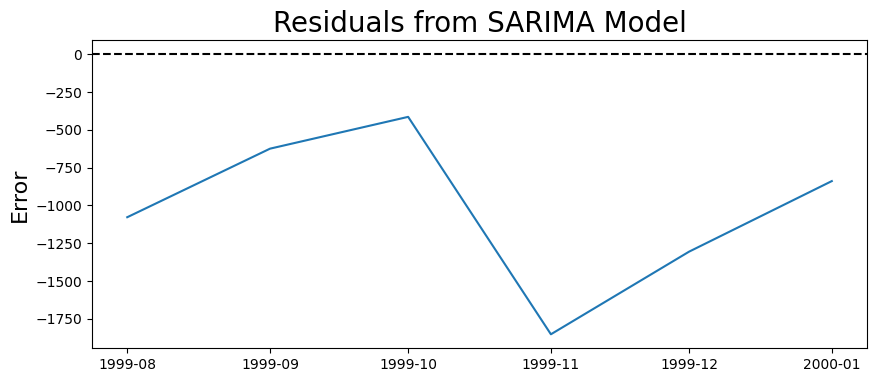

In [14]:
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data - predictions
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

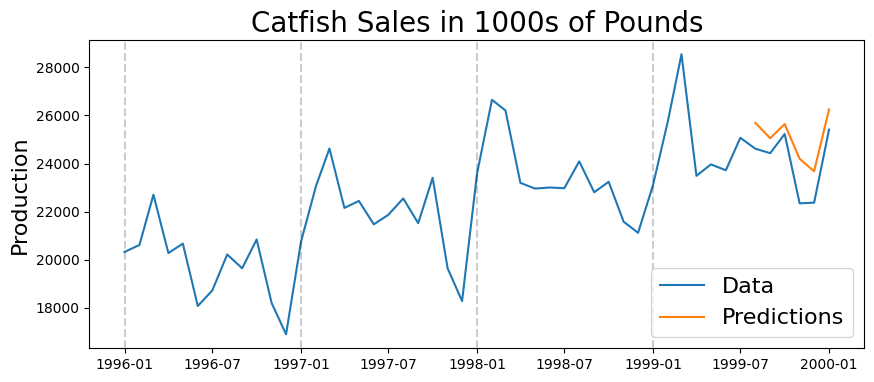

In [15]:
plt.figure(figsize=(10,4))

plt.plot(lim_catfish_sales)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [16]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = lim_catfish_sales[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.10/dist-packages/statsmodel

Text(0, 0.5, 'Error')

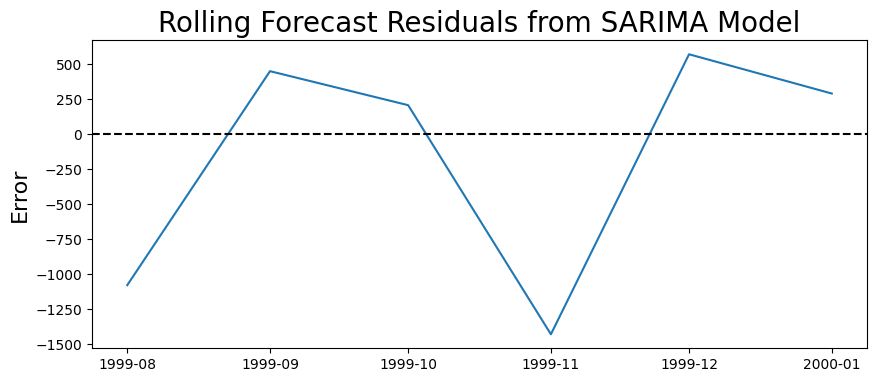

In [17]:
rolling_residuals = test_data - rolling_predictions
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

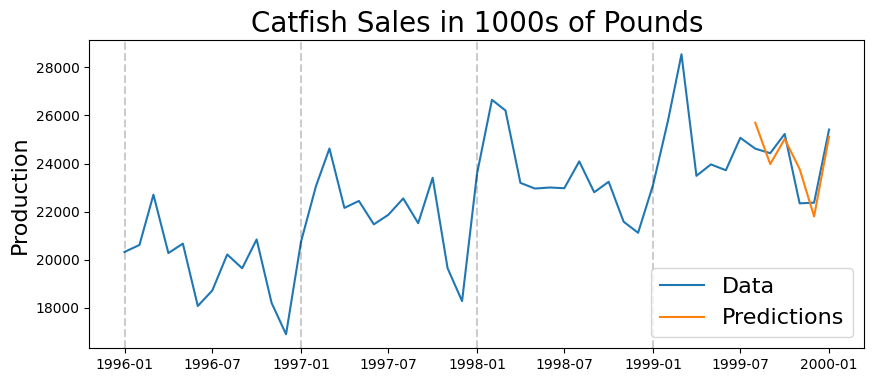

In [18]:
plt.figure(figsize=(10,4))

plt.plot(lim_catfish_sales)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)